In [102]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tensorflow.keras.metrics import AUC, Precision, Recall

from art.utils import load_dataset
from art.estimators.classification import SklearnClassifier
import tensorflow as tf 
from tensorflow.python.framework.ops import disable_eager_execution

# i have no idea why this is necessary but it is 
disable_eager_execution()

In [57]:
#helpers to flatten/unflatten images
def img_to_vector(x):
    return np.reshape(x, (x.shape[0], -1))

def vector_to_img(nbr_samples, x):
    return x.reshape(nbr_samples, 32, 32, 3)

In [58]:
# Load in the data from ART utilities

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

try:
    # try loading data through ART utilities
    (x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10"))
except:
    cifar10 = tf.keras.datasets.cifar10
 
    # Distribute it to train and test set
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    #normalize data 
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    #pixel values between 0 and 1
    x_train  /= 255
    x_test /= 255


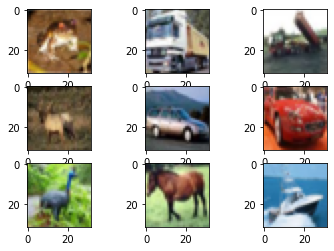

In [59]:
%matplotlib inline

# display a subset of images
def display_img(count, x_train):
    for i in range(count):
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(x_train[i])
    # show the figure
    plt.show()

display_img(9, x_train)

In [65]:
#flattened, non one hot encoded data for vanilla sklearn classifiers
x_train_sk = np.reshape(x_train, (x_train.shape[0], -1))# [10000, 3072]
x_test_sk = np.reshape(x_test, (x_test.shape[0], -1)) # [10000, 3072]
y_train_sk = np.argmax(y_train, axis=1)
y_test_sk = np.argmax(y_test, axis=1)

# _small versions contain only a subset of x and y
# Used for SVC, otherwise it is very slow
x_train_small, y_train_small = x_train[:20000], y_train[:20000]
x_test_small, y_test_small = x_test[:4000], y_test[:4000]

# the _sk versions are modified for using sklearn
# x is flattened and y is changed from one-hot encoded to a single value
x_train_small_sk = np.reshape(x_train_small, (x_train_small.shape[0], -1))
x_test_small_sk = np.reshape(x_test_small, (x_test_small.shape[0], -1))
y_train_small_sk = np.argmax(y_train_small, axis=1)
y_test_small_sk = np.argmax(y_test_small, axis=1)

In [61]:
from sklearn.decomposition import PCA
# Run PCA to reduce number of features
pca = PCA(.90) # number of components to cover 90%

x_train_pca = pca.fit_transform(x_train_sk)
x_test_pca = pca.transform(x_test_sk)

print(x_train_pca.shape, pca.components_.shape)

(50000, 99) (99, 3072)


In [66]:
pca_small = PCA(pca.n_components_) # match nbr components in full pca set
x_train_small_pca = pca_small.fit_transform(x_train_small_sk)
x_test_small_pca = pca_small.transform(x_test_small_sk)

print(x_train_small_pca.shape, pca_small.components_.shape)


(20000, 99) (99, 3072)


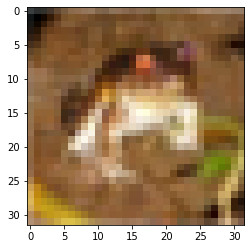

In [62]:
# Example of one original training image
plt.imshow(x_train_sk[0].reshape(32,32,3))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


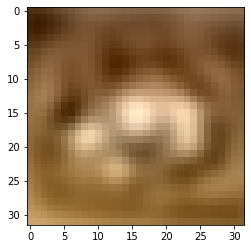

In [63]:
# Example of image using inverse transform of PCA data
# Still semi-recognizable
x_train_pca_inv = pca.inverse_transform(x_train_pca)
plt.imshow(x_train_pca_inv[0].reshape(32, 32, 3))
plt.show()

p=0.4
  Nbr components: 2
p=0.5
  Nbr components: 4
p=0.6
  Nbr components: 8
p=0.7
  Nbr components: 14
p=0.8
  Nbr components: 32
p=0.9
  Nbr components: 98
p=0.95
  Nbr components: 214


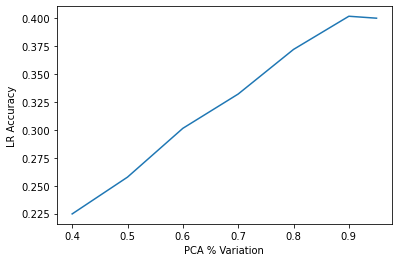

In [67]:
# See how number of components affects accuracy
y_acc = []
x_acc = []
for p in [.4, .5, .6, .7, .8, .9, .95]:
    print(f'p={p}')
    pca_p = PCA(p)
    x_train_small_pcap = pca_p.fit_transform(x_train_small_sk)
    x_test_small_pcap = pca_p.transform(x_test_small_sk)
    print(f'  Nbr components: {pca_p.n_components_}')
    clf_lr_p = LogisticRegression(solver='saga', multi_class='multinomial', tol=0.01)
    clf_lr_p.fit(x_train_small_pcap, y_train_small_sk)
    predict = clf_lr_p.predict(x_test_small_pcap)
    accuracy = metrics.accuracy_score(y_test_small_sk, predict)
    x_acc.append(p)
    y_acc.append(accuracy)
plt.plot(x_acc, y_acc)
plt.xlabel('PCA % Variation')
plt.ylabel('LR Accuracy')
plt.show()   

In [68]:
# Look at confusion matrix
# Helper to plot a confusion matrix for a classifier
def clf_cm(clf, X_test, y_test, title):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, pred) * 100 / X_test.shape[0]
    cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(title + ' (percentages)')
    cm_plt.plot(ax=ax, xticks_rotation=45)
    plt.grid(False)

In [69]:
def model_metrics(model, X_test, y_test):
    pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred)
    y_prob = model.predict_proba(X_test)
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    return accuracy, macro_roc_auc_ovr

In [70]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def roc_multi(clf, X_train, y_train, X_test, y_test):
    classifier = OneVsRestClassifier(clf)
    y_score = classifier.fit(X_train, y_train).predict(X_test)
    legends=[]
    plt.figure(figsize = (10,7))
    for i, e in enumerate(classifier.estimators_):
        probs = e.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test[:, i], probs[:, 1])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr)
        legends.append(classes[i] + f' auc= {auc:.2f}')
    plt.legend(legends, loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(type(clf).__name__)
    plt.show()

In [71]:
from sklearn.model_selection import GridSearchCV
# Helper to run GridSearchCV
def runGridSearch(estimator, parameters, x_train, y_train, x_test, y_test):
    gscv = GridSearchCV(estimator=estimator, param_grid=parameters, verbose=4, n_jobs=4, refit=True)
    gscv.fit(x_train, y_train)
    print(gscv.best_estimator_)
    print(f'Best train score: {gscv.best_score_}')
    predict = gscv.best_estimator_.predict(x_test)
    print(f'{gscv.best_estimator_}: test accuracy={metrics.accuracy_score(y_test, predict)}')  

In [44]:
# Run GridSearchCV on logistic Regression options
from sklearn.linear_model import LogisticRegression
lr_parameters = {'penalty': ('l2', 'none'), 'tol': (1.0e-2, 1.0e-4)}
lr_model = LogisticRegression(solver='saga', multi_class='multinomial')
runGridSearch(lr_model, lr_parameters, x_train_pca, y_train_sk, x_test_pca, y_test_sk)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
LogisticRegression(multi_class='multinomial', penalty='none', solver='saga',
                   tol=0.01)
Best train score: 0.39714
LogisticRegression(multi_class='multinomial', penalty='none', solver='saga',
                   tol=0.01): test accuracy=0.4018


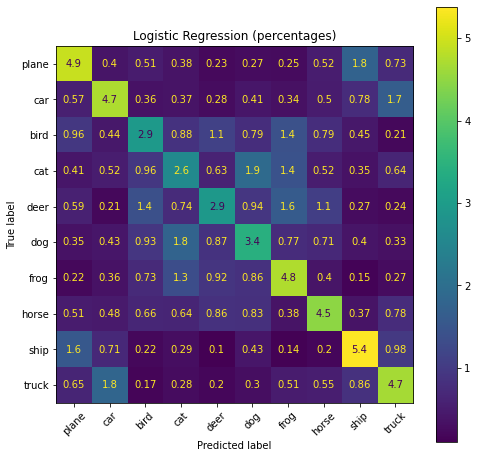

In [74]:
clf_cm(lr_model, x_test_sk, y_test_sk, 'Logistic Regression')

In [75]:
print(model_metrics(lr_model, x_test_sk, y_test_sk))

(0.4084, 0.8174693333333334)


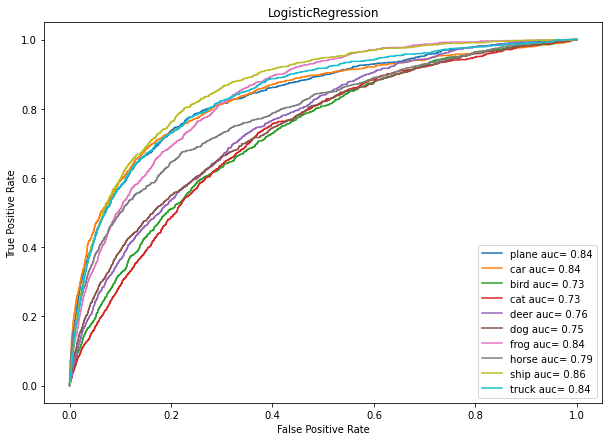

In [76]:
roc_multi(lr_model, x_train_sk, y_train, x_test_sk, y_test)

In [45]:
# Run GridSearchCV on decision tree options
dt_parameters = {'max_depth': (10, 20, 50), 'max_features': ('auto', None)}
runGridSearch(DecisionTreeClassifier(), dt_parameters, x_train_pca, y_train_sk, x_test_pca, y_test_sk)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
DecisionTreeClassifier(max_depth=10)
Best train score: 0.30678
DecisionTreeClassifier(max_depth=10): test accuracy=0.3108


In [46]:
# Run GridSearchCV on Random Forest options
rf_parameters = {'n_estimators': (25,50,100), 'max_depth':(10,50,100)}
runGridSearch(RandomForestClassifier(n_jobs=4), rf_parameters, x_train_pca, y_train_sk, x_test_pca, y_test_sk)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
RandomForestClassifier(max_depth=100, n_jobs=4)
Best train score: 0.45316
RandomForestClassifier(max_depth=100, n_jobs=4): test accuracy=0.4711


In [ ]:
# Try SVC on the PCA data (warning - this is still slow!!)
clf_svc = SVC(C=4, kernel='linear', verbose=2)
clf_svc.fit(x_train_small_pca, y_train_small_sk)
predict = clf_svc.predict(x_test_small_pca)
metrics.accuracy_score(y_test_small_sk, predict)

In [95]:
# neural network model
# model from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/adversarial_training_cifar10.py
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential


model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)       

In [107]:
# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

In [108]:
# Fit
r = model.fit(
  x_train, y_train_sk, validation_split=0.33, epochs=10)

Train on 33500 samples, validate on 16500 samples
Epoch 1/10


InvalidArgumentError: Incompatible shapes: [200,320] vs. [200,32]
	 [[{{node metrics_12/auc/LogicalAnd}}]]

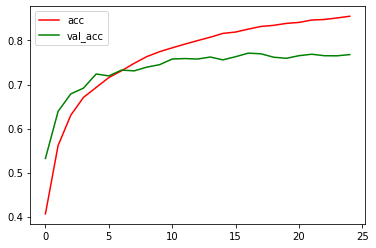

In [98]:
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [100]:
x = model.evaluate(x_test, y_test_sk, verbose=1)
print(x)

[0.7522925172328949, 0.7678]


Original label is cat and predicted label is cat


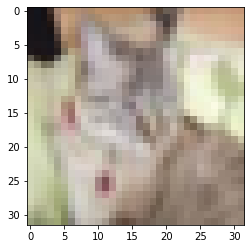

In [52]:
# select the image from our test dataset
image_number = 8
 
# display the image
plt.imshow(x_test[image_number])
 
# load the image in an array
n = np.array(x_test[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = classes[model.predict(p).argmax()]
 
# load the original label
original_label = classes[np.argmax(y_test, axis=1)[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [78]:
# Create classifier wrappers for trained models
keras_classifier = KerasClassifier(model=model, clip_values=(0, 1))
logreg_classifier = SklearnClassifier(model=lr_model, clip_values=(0, 1))
#svc_classifier = SklearnClassifier(model=svc_model, clip_values=(min_, max_))

#train classifiers 
logreg_classifier.fit(x_train_sk, y_train)
#svc_classifier.fit(x_train, y_train)
keras_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 45s 892us/sample - loss: 0.3648 - accuracy: 0.8699
Epoch 2/10
50000/50000 [==============================] - 45s 897us/sample - loss: 0.3353 - accuracy: 0.8800
Epoch 3/10
50000/50000 [==============================] - 45s 896us/sample - loss: 0.3242 - accuracy: 0.8844
Epoch 4/10
50000/50000 [==============================] - 45s 897us/sample - loss: 0.3219 - accuracy: 0.8854
Epoch 5/10
50000/50000 [==============================] - 45s 895us/sample - loss: 0.3174 - accuracy: 0.8872
Epoch 6/10
50000/50000 [==============================] - 45s 897us/sample - loss: 0.3077 - accuracy: 0.8903
Epoch 7/10
50000/50000 [==============================] - 45s 903us/sample - loss: 0.3057 - accuracy: 0.8911
Epoch 8/10
50000/50000 [==============================] - 45s 903us/sample - loss: 0.3122 - accuracy: 0.8883
Epoch 9/10
50000/50000 [==============================] - 46s 927us/sample - loss: 0.3021 - accuracy: 0.8

In [26]:
logreg_classifier.fit(x_train_flat, y_train)

In [79]:
# DeepFool attack for neural networks
from art.attacks.evasion import DeepFool

print("Create DeepFool attack")
adv_crafter = DeepFool(keras_classifier)
print("Craft attack test examples")
x_test_df = adv_crafter.generate(x_test)

Create DeepFool attack
Craft attack test examples


DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
# Evaluate the trained model on the adversarial samples
preds = np.argmax(model.predict(x_test_df), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Model before adversarial training")
print("Accuracy on adversarial samples: ", (acc * 100))

Model before adversarial training
Accuracy on adversarial samples:  15.43


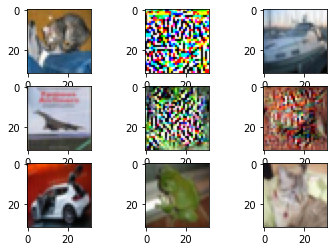

In [80]:
display_img(9, x_test_df)

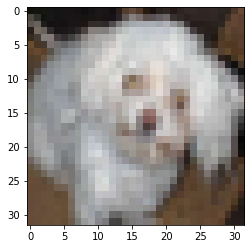

In [81]:
plt.imshow(x_test[1000])

Original label is plane and predicted label is ship


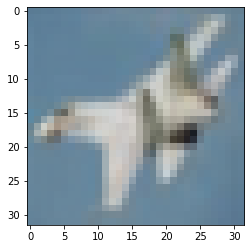

In [83]:
# select random image from DeepFool generated testing set 
image_number = 10
 
# display the image
plt.imshow(x_test_df[image_number])
 
# load the image in an array
n = np.array(x_test_df[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
# pass in the network for prediction and
# save the predicted label
predicted_label = classes[model.predict(p).argmax()]
 
# load the original label
original_label = classes[y_test_sk[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [28]:
#Fast gradient method on neural network
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(estimator=keras_classifier, eps=0.1)
x_test_fgm = attack.generate(x=x_test)
preds = np.argmax(model.predict(x_test_fgm), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  19.919999999999998


In [27]:
from art.attacks.evasion import FastGradientMethod
#fast gradient method on logistic regression
attack = FastGradientMethod(estimator=logreg_classifier, eps=0.1)
x_test_fgm_sk = attack.generate(x=x_test_sk)
preds = lr_model.predict(x_test_fgm_sk)
acc = lr_model.score(x_test_fgm_sk, y_test_sk)
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  17.990000000000002


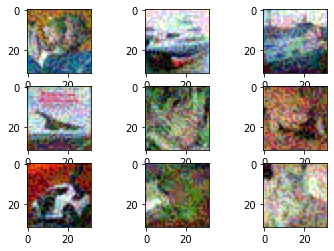

In [29]:
display_img(9, x_test_fgm_sk.reshape(x_test_fgm_sk.shape[0], 32, 32, 3))

Original label is ship and predicted label is frog


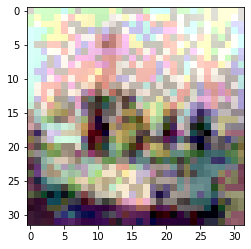

In [32]:
# select the image from our test dataset
image_number = 88
 
# display the image
plt.imshow(x_test_fgm_sk.reshape(x_test_fgm_sk.shape[0], 32, 32, 3)[image_number])
 
# load the image in an array
n = np.array(x_test_fgm_sk.reshape(x_test_fgm_sk.shape[0], 32, 32, 3)[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = classes[model.predict(p).argmax()]
 
# load the original label
original_label = classes[y_test_flat[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [77]:
# try a defense. 
from art.defences.preprocessor import JpegCompression
defense = JpegCompression(clip_values=(0,1))
data = defense.__call__(x_test_df)

In [90]:
# try compressed testing data on trained model
preds = np.argmax(model.predict(data[0]), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Model before adversarial training")
print("Accuracy on adversarial samples: ", (acc * 100))

Model before adversarial training
Accuracy on adversarial samples:  8.55
